In [1]:

import pandas as pd
import numpy as np
import sys
import traceback
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn as skl
import dataclasses
import os



import pickle

In [2]:
dataset: Literal["ihdp","jobs"] = "ihdp"

In [3]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())

sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [4]:
_seed: Final[int] = 42
"Using the meaning of life, the universe, and everything as the seed for RNG"

def rng() -> np.random.Generator:
    """
    Creates a new numpy random generator with a seed of 42.
    :return: a new numpy random generator with a seed of 42
    """
    return np.random.default_rng(seed=_seed)

def rng_state() -> np.random.RandomState:
    """
    Creates a new numpy randomstate with a seed of 42
    :return: a new numpy randomstate with a seed of 42
    """
    return np.random.RandomState(seed=_seed)

""

''

# IHDP dataset processing


In [5]:
def turn_01_columns_into_int(
        dataframe_to_edit: pd.DataFrame,
) -> pd.DataFrame:
    """
    Finds all of the columns that just contain values of 0 and 1,
    and converts all of those columns to ints.

    Dataframe will have an '01' and 'not_01' attr added to it.
    Labels for series that only contain values 0 and 1 will be in the '01' tuple
    Labels for every other series will be in the 'not_01' tuple

    MODIFIES THE GIVEN DATAFRAME!
    :param dataframe_to_edit: the dataframe that is being edited
    :return: The modified dataframe.
    DOES NOT COPY THE GIVEN ORIGINAL DATAFRAME.

    >>> import pandas as pd
    >>> print(pd.__version__)
    1.4.1
    >>> before: pd.DataFrame = pd.DataFrame.from_dict(data={"int01":[0,1,1,0],"flt01":[0.0, 1.0, 0.0, 1.0], "intNo": [-1,0,1,2], "fltNo":[-1.0, 0.0, 1.0, 2.0], "intNan": [0,1,None,0], "fltNan":[0.0,1.0,None,0.0]})
    >>> before_types = before.dtypes.values
    >>> after: pd.DataFrame = turn_01_columns_into_int(before.copy())
    >>> after_types = after.dtypes.values
    >>> print(after_types[0])
    uint8
    >>> print(after_types[1])
    uint8
    >>> print(f"{before_types[2] == after_types[2]} {before_types[3] == after_types[3]} {before_types[4] == after_types[4]} {before_types[5] == after_types[5]}")
    True True True True
    >>> print(f"{after.attrs['01']}")
    ('int01', 'flt01')
    >>> print(f"{after.attrs['not_01']} ")
    ('intNo', 'fltNo', 'intNan', 'fltNan')
    """
    cols_01: List[str] = []
    not_01:  List[str] = []
    for c in dataframe_to_edit.columns:
        #if dataframe_to_edit[c].dtype == np.uint8:
        #    continue
        if dataframe_to_edit[c].isin([0,1]).all():
            dataframe_to_edit[c] = dataframe_to_edit[c].astype(np.uint8)
            cols_01.append(c)
        else:
            not_01.append(c)
    dataframe_to_edit.attrs["01"] = tuple(cols_01)
    dataframe_to_edit.attrs["not_01"] = tuple(not_01)
    return dataframe_to_edit

In [6]:

ihdp_full: pd.DataFrame = turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full IHDP dataset (with supplementary t0 and t1 info) as a dataframe"

ihdp_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x21,x22,x23,x24,t,yf,ycf,ite,t0,t1
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,0,0,1,1,4.771232,-0.298509,4.657928,-0.298509,4.771232
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,0,0,0,0,0,2.956273,5.783770,3.428604,2.956273,5.783770
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,0,0,0,1,0,4.164164,7.055789,3.658195,4.164164,7.055789
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,0,0,0,0,1,6.172307,1.379697,4.585505,1.379697,6.172307
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,0,0,0,0,1,7.834469,2.747986,4.265591,2.747986,7.834469


In [7]:
ihdp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      747 non-null    float64
 1   x1      747 non-null    float64
 2   x2      747 non-null    float64
 3   x3      747 non-null    float64
 4   x4      747 non-null    float64
 5   x5      747 non-null    float64
 6   x6      747 non-null    uint8  
 7   x7      747 non-null    uint8  
 8   x8      747 non-null    uint8  
 9   x9      747 non-null    uint8  
 10  x10     747 non-null    uint8  
 11  x11     747 non-null    uint8  
 12  x12     747 non-null    uint8  
 13  x13     747 non-null    uint8  
 14  x14     747 non-null    uint8  
 15  x15     747 non-null    uint8  
 16  x16     747 non-null    uint8  
 17  x17     747 non-null    uint8  
 18  x18     747 non-null    uint8  
 19  x19     747 non-null    uint8  
 20  x20     747 non-null    uint8  
 21  x21     747 non-null    uint8  
 22  x2

In [35]:
ihdp_factuals: pd.DataFrame = ihdp_full.loc[:, ~ihdp_full.columns.isin(
    ["ycf","ite","t0","t1"]
)]
"A version of the IHDP dataset containing ONLY the factual data"

ihdp_factuals_no_y: pd.DataFrame = ihdp_factuals.loc[:, ihdp_factuals.columns != "yf"]
"IHDP dataset with the factual Y omitted"



ihdp_factuals_y: pd.DataFrame = ihdp_factuals.loc[:, ihdp_factuals.columns == "yf"]
"Only the Y data from the IHDP dataset"

ihdp_full_nonfactuals: pd.DataFrame = ihdp_full.loc[:, ihdp_full.columns.isin(
    ["ycf","ite","t0","t1"]
)]
"IHDP dataset except it's just the non-factual data"


"IHDP dataset except it's just the non-factual data"

In [9]:

from sklearn.model_selection import StratifiedKFold, train_test_split

#ihdp_learn_validation_skf: StratifiedKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=_seed)
#"Using this to remove 10% of the treated/untreated factuals from ihdp for use as part of the validation dataset later on"

#ihdp_learn_indices, ihdp_validation_indices = [i for i in ihdp_learn_validation_skf.split(ihdp_factuals, ihdp_factuals["t"])][0]

ihdp_learn_full_df, ihdp_validation_full_df = train_test_split(
    ihdp_full,
    test_size=0.1,
    random_state=rng_state(),
    shuffle=True,
    stratify=ihdp_full["t"]
)

ihdp_learn_df: pd.DataFrame = ihdp_learn_full_df.loc[:, ~ihdp_learn_full_df.columns.isin(
    ["ycf","ite","t0","t1"]
)]
"The dataframe that is the subset of the IHDP factual data which will be used for learning feature importances etc"

ihdp_learn_df_x: pd.DataFrame = ihdp_learn_df.loc[:, ihdp_learn_df.columns != "yf"]
"X/T info for the dataframe that is the subset of the IHDP factual data which will be used for learning feature importances etc"
ihdp_learn_df_y: pd.DataFrame = ihdp_learn_df.loc[:, ihdp_learn_df.columns == "yf"]
"Y info for the dataframe that is the subset of the IHDP factual data which will be used for learning feature importances etc"

ihdp_learn_ite: pd.DataFrame = ihdp_learn_full_df.loc[:,ihdp_learn_full_df.columns=="ite"]

ihdp_validation_factual_df: pd.DataFrame = ihdp_validation_full_df.loc[:, ~ihdp_validation_full_df.columns.isin(
    ["ycf","ite","t0","t1"]
)]
ihdp_validation_factual_df_x: pd.DataFrame = ihdp_validation_factual_df.loc[:, ihdp_validation_factual_df.columns != "yf"]
ihdp_validation_factual_df_y: pd.DataFrame = ihdp_validation_factual_df.loc[:, ihdp_validation_factual_df.columns == "yf"]

""

''

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection._validation import NotFittedError
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.linear_model import ARDRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.metrics import r2_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from math import inf

set_config(display="diagram")

R = TypeVar('R', bound=RegressorMixin)

In [11]:
def get_importances_mdi(regressor: Union[R, Pipeline], regressor_step: str = "regressor") -> np.ndarray:
    """
    Obtains min decrease in impurity feature importances for a given regressor
    :param regressor: the regressor we want the MDI-based importances of
    :param regressor_step: if given a pipeline, this is the name of the pipeline step that holds the regressor itself
    :return: np.ndarray of the feature importances of the regressor.
    """

    try:
        return regressor.feature_importances_
    except AttributeError as e1:
        try:
            return regressor.coef_.flatten()
        except AttributeError as e2:
            try:
                return np.mean([get_importances_mdi(p) for p in regressor.estimators_],axis=0)
            except AttributeError as e3:
                return get_importances_mdi(regressor[regressor_step])



def get_importance_mdi_std(regressor: Union[R, Pipeline], regressor_step: str = "regressor") -> np.ndarray:
    """
    Obtains standard deviation of min decrease in impurity feature importances for a given regressor
    :param regressor: the regressor we want the MDI-based importances of
    :param regressor_step: if given a pipeline, this is the name of the pipeline step that holds the regressor itself
    :return: np.ndarray of the feature importances of the regressor.
    """
    try:
        return np.std([get_importances_mdi(p) for p in regressor.estimators_],axis=0)
    except AttributeError as e1:
        try:
            return np.std([get_importances_mdi(regressor)],axis=0)
        except AttributeError as e2:
            return get_importance_mdi_std(regressor[regressor_step])


@dataclasses.dataclass(init=True, eq=True, repr=True, frozen=True)
class HalvingGridSearchResults:

    gridSearch: HalvingGridSearchCV

    estimator_type: str

    dataset_name: str

    test_indices: np.ndarray

    x_t_column_names: Tuple[str]

    predictions: pd.DataFrame

    feature_importances: pd.DataFrame

    gridsearch_train_r2_score: float

    validation_fold_r2_score: float

    yf_r2_score: float


    # these will use a dummy value of 42 (because r2 score of 42 is impossible, and it's less ugly than a None)
    ycf_r2_score: float
    t0_r2_score: float
    t1_r2_score: float
    ite_r2_score: float

    @property
    def has_counterfactual_score(self) -> bool:
        return self.ycf_r2_score <= 1

    @property
    def has_ite_score(self) -> bool:
        return self.ite_r2_score <= 1

    @property
    def has_t0_t1_scores(self) -> bool:
        return self.t0_r2_score <= 1 and self.t1_r2_score <= 1


    def summary_info(self) -> str:
        return f"GridSearchResults summary {self.estimator_type} {self.dataset_name}\n" \
               f"\ttest r2: {self.validation_fold_r2_score}\n" \
               f"\ttrain r2:{self.gridsearch_train_r2_score}\n" \
               f"\tyf r2:   {self.yf_r2_score}"


    def info(self) -> str:
        out_string: str = f"GridSearchResults: {self.estimator_type} {self.dataset_name}\n" \
                          f"\testimator: {self.best_estimator_}\n" \
                          f"\ttest r2: {self.validation_fold_r2_score}\n" \
                          f"\ttrain r2:{self.gridsearch_train_r2_score}\n" \
                          f"\tyf r2:   {self.yf_r2_score}"
        if self.has_counterfactual_score:
            out_string = out_string + f"\n\tycf r2:  {self.ycf_r2_score}"
        if self.has_ite_score:
            out_string = out_string + f"\n\tite r2:  {self.ite_r2_score}"
        if self.has_t0_t1_scores:
            out_string = out_string + f"\n\tt0 r2:   {self.t0_r2_score}" \
                                      f"\n\tt1 r2:   {self.t1_r2_score}"

        return out_string




    def __lt__(self, other: "HalvingGridSearchResults") -> bool:

        if self.validation_fold_r2_score < other.validation_fold_r2_score:
            return True
        elif self.validation_fold_r2_score == other.validation_fold_r2_score:

            if self.has_ite_score and other.has_ite_score:
                if self.ite_r2_score < other.ite_r2_score:
                    return True
                elif self.ite_r2_score > other.ite_r2_score:
                    return False
            if self.has_counterfactual_score <= 1 and other.has_counterfactual_score <= 1:
                if self.ycf_r2_score < other.ycf_r2_score:
                   return True
                elif self.ycf_r2_score > other.ycf_r2_score:
                    return False
            if self.has_t0_t1_scores and other.has_t0_t1_scores:
                # basically the r2 scores for t1 and t0 are shifted down to
                # have an upper limit of -1, then the products of the
                # shifted r2 scores are found.
                # higher product = worse r2 scores: counted as 'less than'
                # returns true if this object's combined r2 is worse than other.
                if (
                   (self.t0_r2_score-2) * (self.t1_r2_score-2)
                ) > (
                    (other.t0_r2_score-2) * (other.t1_r2_score-2)
                ):
                    return True
                else:
                    return False
            # otherwise compare the factual r2 scores
            return self.yf_r2_score < other.yf_r2_score
        # this is not less than the other thing
        return False


    @property
    def best_estimator_(self) -> R:
        return self.gridSearch.best_estimator_

    def plot_feature_importances(
            self,
            ax: plt.Axes,
            permutation: bool = True
    ) -> plt.Axes:
        """
        Plots feature importances (using matplotlib stuff)
        :param ax: the matplotlib axes we're trying to plot feature importances on
        :param permutation: if true, we plot the feature importances calculated from a permutation test on the test set. If false, we work out mean decrease in impurity
        :return: the axes with feature importances plotted on them
        """

        importance: np.ndarray = np.zeros_like(self.feature_importances.index)
        error: np.ndarray = np.zeros_like(self.feature_importances.index)

        y_label: str = "PLACEHOLDER"
        plot_title: str = "PLACEHOLDER"

        if permutation:

            importance = self.feature_importances["importances_mean"].values
            error = self.feature_importances["importances_std"].values

            plot_title = f"{self.dataset_name} feature importances using permutation for {self.estimator_type}"

            y_label = "Mean accuracy decrease"

        else:


            importance = get_importances_mdi(self.best_estimator_["regressor"])
            error = get_importance_mdi_std(self.best_estimator_["regressor"])

            plot_title = f"{self.dataset_name} feature importances using Mean Decrease in Impurity (no permutation) for {self.estimator_type}"

            y_label = "Mean decrease in impurity"

        bar: matplotlib.container.BarContainer = ax.bar(
            self.x_t_column_names,
            importance,
            yerr=error
        )

        ax.bar_label(
            bar,
            labels=[
                f'{val:.3f}\n±{err:.2f}'
                for val, err in zip(importance, error)
            ]
        )

        ax.axhline(0, color='grey', linewidth=0.8)

        ax.grid(visible=True, which="both", axis="both")

        ax.set_title(plot_title)
        ax.set_ylabel(y_label)
        ax.set_xlabel("feature names")

        return ax

    def importance_plotter(self) -> plt.Figure:

        faa: Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]] = plt.subplots(
            nrows=2,
            ncols=1,
            squeeze=True,
            figsize=(16,18)
        )

        fig: plt.Figure = faa[0]
        axs: Tuple[plt.Axes, plt.Axes] = faa[1]

        for ax, perm in zip(axs, [False, True]):

            self.plot_feature_importances(ax, perm)

        fig.suptitle(f"{self.dataset_name} feature importance graphs for {self.estimator_type}")
        fig.tight_layout()
        fig.savefig(
            fname=os.getcwd() + "\\" + f"{self.dataset_name}" + "\\" + f"{self.dataset_name} {self.estimator_type} feature importances.pdf"
        )

        return fig


    def save_me(self) -> NoReturn:

        path: str = os.getcwd() + "\\" + f"{self.dataset_name}" + "\\"

        results_go_here: str = path + f"{self.dataset_name} {self.estimator_type} simple results.pickle"

        estimator_goes_here: str = path + f"{self.dataset_name} {self.estimator_type} simple estimator.pickle"

        print(f"Pickling results to: {results_go_here}")

        with open(results_go_here, "wb") as resultsPickle:
            pickle.dump(self, resultsPickle)
            print("pickled results!")

        print(f"Pickling simple estimator to {estimator_goes_here}")

        with open(estimator_goes_here, "wb") as estPickle:
            pickle.dump(self.best_estimator_, estPickle)
            print("pickled estimator!")


    @classmethod
    def make(
            cls,
            searcher: HalvingGridSearchCV,
            estimator_type: str,
            all_x_data: pd.DataFrame,
            factual_y_data: pd.DataFrame,
            test_indices: np.ndarray,
            true_t0_t1_ite_ycf: Optional[pd.DataFrame] = None,
    ) -> "HalvingGridSearchResults":

        this_x: pd.DataFrame = all_x_data.copy()

        this_x_y: pd.DataFrame = this_x.copy()

        train_r2_score: float = searcher.best_score_

        validation_r2_score: float = searcher.score(
            this_x.values[test_indices],
            factual_y_data.values[test_indices]
        )

        importance_results: Bunch = permutation_importance(
            searcher,
            this_x.values[test_indices],
            factual_y_data.values[test_indices],
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )

        importance_df: pd.DataFrame = pd.DataFrame()
            # TODO: each entry of importance_results mapped to each column name from this_x

        x_t_names: Tuple[str] = tuple(this_x.columns.values)

        importance_df["features"] = this_x.columns.values

        importance_df["importances_mean"] = importance_results.importances_mean
        importance_df["importances_std"] = importance_results.importances_std
        importance_df["importances"] = importance_results.importances.tolist()

        importance_df.set_index("features")

        this_x_y["yf"] = searcher.predict(
            this_x.to_numpy()
        )

        factual_r2_score: float = r2_score(
            factual_y_data.to_numpy(),
            this_x_y["yf"].to_numpy()
        )

        this_x["t"] = np.choose(this_x["t"].values,[1,0])

        this_x_y["ycf"] = searcher.predict(
            this_x.to_numpy()
        )



        this_x["t"] = 0

        this_x_y["t0"] = searcher.predict(this_x.to_numpy())

        this_x["t"] = 1

        this_x_y["t1"] = searcher.predict(this_x.to_numpy())

        this_x_y["ite"] = this_x_y["t1"] - this_x_y["t0"]

        # dummy values of 42 because  r2 score of 42 is impossible.
        ycf_score: float = 42
        t0_score: float = 42
        t1_score: float = 42
        ite_score: float = 42

        if true_t0_t1_ite_ycf is not None:
            ycf_score = r2_score(
                true_t0_t1_ite_ycf["ycf"].to_numpy(),
                this_x_y["ycf"].to_numpy()
            )
            t0_score = r2_score(
                true_t0_t1_ite_ycf["t0"].to_numpy(),
                this_x_y["t0"].to_numpy()
            )
            t1_score = r2_score(
                true_t0_t1_ite_ycf["t1"].to_numpy(),
                this_x_y["t1"].to_numpy()
            )
            ite_score = r2_score(
                true_t0_t1_ite_ycf["ite"].to_numpy(),
                this_x_y["ite"].to_numpy()
            )

        return HalvingGridSearchResults(
            gridSearch=searcher,
            dataset_name=dataset,
            estimator_type=estimator_type,
            test_indices=test_indices,
            x_t_column_names=x_t_names,
            predictions=this_x_y,
            feature_importances=importance_df,
            gridsearch_train_r2_score=train_r2_score,
            validation_fold_r2_score=validation_r2_score,
            yf_r2_score=factual_r2_score,
            ycf_r2_score=ycf_score,
            t0_r2_score=t0_score,
            t1_r2_score=t1_score,
            ite_r2_score=ite_score
        )








In [12]:
def np_data_and_targets(
        df: pd.DataFrame,
        targetname: str = "yf"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Converts dataframe into a couple of numpy ndarrays for the data without the labels,
    and the labels by themselves.
    :param df: the Dataframe
    :param targetname: The name of the column holding the targets
    :return: tuple of [ndarray of the values without the targets, just the class labels]
    """

    inputs:  np.ndarray = df.loc[:,df.columns != targetname].to_numpy()
    outputs: np.ndarray =  df.loc[:,targetname].to_numpy()

    return inputs, outputs

In [13]:
def fallback_w_h_calc(split_this: int) -> Tuple[int, int]:
    h = np.floor(np.sqrt(split_this))
    # get something relatively close to the square
    w = split_this//h

    i_w = w < h
    if w * h < split_this:
        if i_w:
            w += 1
        else:
            h += 1
        i_w = not i_w
    return w, h

def w_h_finder(value_to_split: int) -> Tuple[int, int]:
    w: int = 1
    h: int = value_to_split
    if np.sqrt(value_to_split) % 1 == 0:  # if the filter count is a square number
        w = h = np.floor(np.sqrt(value_to_split))  # nice square layout for plots
    elif value_to_split & 1 == 1:  # if odd number of filter items
        w, h = fallback_w_h_calc(value_to_split)
    else:
        # if filter count is even, we work out which binary rectangle works best basically
        a: int = 1
        b: int = value_to_split
        while b > a and b & 1 == 0:
            b //= 2
            a *= 2
        if max(a, b) > min(a, b) * 2:
            w, h = fallback_w_h_calc(value_to_split)
        else:
            w = max(a, b)
            h = min(a, b)
    return int(w), int(h)


def factor_finder(split_this: int) -> Tuple[int, int]:

    # find the factor with most splits for split_this.
    # for i in range(1, sqrt)

    #floor_sqrt: int = np.floor(np.sqrt(split_this))

    factors: Dict[int, Tuple[int, int]] = dict(
        (i, factor_tester(split_this, i)) for i in range(2, int(np.ceil(np.sqrt(split_this))) + 1)
    )

    best_so_far: Tuple[int, int, int] = (-1, -1, 0)

    for k, v in factors.items():
        if v[1] > best_so_far[2]:
            best_so_far = (k, v[0],v[1])

    if best_so_far[2] == 0:
        return w_h_finder(split_this)
    else:
        return best_so_far[1], best_so_far[0]


def factor_tester(split_this: int, factor: int, tally: int = 0) -> Tuple[int, int]:
    # TODO: how many times can split_this be int divided by i? result of doing these chained divisions?
    # return div count of 0 if can't split.

    splitted = split_this / factor
    if (splitted % 1) == 0:
        tally += 1
        return factor_tester(split_this//factor, factor, tally)
    else:
        return split_this, tally


In [14]:

def halving_grid_searcher(
        regressor: R,
        param_grid: Dict[str, List[Any]],
        train_data: np.ndarray,
        train_targets: np.ndarray,
        k_folds: Union[KFold, Iterable[Tuple[np.ndarray, np.ndarray]]] = KFold(n_splits=9, shuffle=False),
        class_weights: Optional[np.ndarray] = None,
        resource: str = "n_samples"
) -> HalvingGridSearchCV:

    pipe: Pipeline = Pipeline([
        ("scaler", QuantileTransformer(output_distribution="normal")),
        ("imputer",KNNImputer(add_indicator=False, weights="distance")),
        ("regressor",regressor)
    ])

    n_splits: int = k_folds.get_n_splits() if isinstance(k_folds, skl.model_selection.BaseCrossValidator) else len(k_folds)

    n_max_resources: int = train_targets.size if resource=="n_samples" else pipe.get_params(deep=True)[resource]

    min_res, factor = factor_finder(n_max_resources) #w_h_finder(n_max_resources)

    print(f"max: {n_max_resources}, min: {min_res}, factor: {factor}")


    h_grid_search: HalvingGridSearchCV = HalvingGridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        factor=factor,
        cv=k_folds,
        scoring=make_scorer(r2_score),
        refit=True,
        verbose=1,
        n_jobs=-1,
        aggressive_elimination=True,
        error_score=-1000000000000,
        # I wanted to make this error score negative infinity, however, doing so caused a lot of
        # particularly unsightly warning messages to appear.

        # So, to save everyone involved from having to look at at a buttload of them with a buttload of numbers in them,
        # I'm just setting this to an incredibly low finite number which should be rather hard to reach.
        # And if this score (or an even lower score) somehow is reached legitimately, chances are that
        # the legitimate score being lower than the error score will be the least of one's concerns.
        resource=resource,
        max_resources= n_max_resources,
        min_resources= min_res #n_max_resources//4
    )

    if class_weights is not None:

        h_grid_search.fit(
            train_data, train_targets, sample_weight=class_weights
        )
    else:
        h_grid_search.fit(
            train_data, train_targets
        )

    return h_grid_search



In [15]:
def nested_halving_grid_searcher(
        regressor: R,
        param_grid: Dict[str, List[Any]],
        learn_x_t_data: pd.DataFrame,
        learn_y_targets: pd.DataFrame,
        regressor_name: str,
        kfold_splits: int =  10,
        learn_classes: Optional[np.ndarray] = None,
        using_class_weights: bool = False,
        nested_rng_generator: Optional[np.random.RandomState] = None,
        resource: str = "n_samples",
        true_t0_t1_ite_ycf: Optional[pd.DataFrame] = None
) -> List[HalvingGridSearchResults]:

    if nested_rng_generator is None:
        nested_rng_generator = rng_state()

    h_grid_search_dicts: Dict[HalvingGridSearchCV, float] = {}

    results: List[HalvingGridSearchResults] = []

    the_splits: Iterable[np.ndarray, np.ndarray] = []

    child_splits: int = max(1, kfold_splits-1)
    child_kf: Union[KFold, Iterable[Tuple[np.ndarray, np.ndarray]]] = KFold(n_splits=child_splits, shuffle=False)

    if learn_classes is None:

        using_class_weights = False

        my_kf: KFold = KFold(
            n_splits=kfold_splits,
            shuffle=True,
            random_state=nested_rng_generator
        )
        the_splits = my_kf.split(learn_x_t_data.values, learn_y_targets.values)

    else:

        my_kf: StratifiedKFold = StratifiedKFold(
            n_splits=kfold_splits,
            shuffle=True,
            random_state=nested_rng_generator
        )

        the_splits = my_kf.split(np.zeros_like(learn_classes), learn_classes)




    for i, (train_indices, test_indices) in enumerate(the_splits, 1):
        print(f"-- {i}/{kfold_splits} start --")
        try:


            if learn_classes is not None:
                child_kf = [
                    j for j in StratifiedKFold(
                        n_splits=child_splits,
                        shuffle=False
                    ).split(
                        X = np.zeros_like(train_indices),
                        y = learn_classes[train_indices]
                    )
                ]

            if using_class_weights:

                train_classes: np.ndarray = np.take(learn_classes, train_indices)

                train_classes = train_classes / np.sum(train_classes)

                test_classes: np.ndarray = np.take(learn_classes, test_indices)
                test_classes = test_classes / np.sum(test_classes)

                current_search: HalvingGridSearchCV = halving_grid_searcher(
                    regressor,
                    param_grid,
                    learn_x_t_data.values[train_indices],
                    learn_y_targets.values[train_indices],
                    child_kf,
                    class_weights = train_classes,
                    resource=resource
                )

                results.append(
                    HalvingGridSearchResults.make(
                        current_search,
                        regressor_name,
                        learn_x_t_data,
                        learn_y_targets,
                        test_indices,
                        true_t0_t1_ite_ycf
                    )
                )

                current_score: float = current_search.score(
                    learn_x_t_data.values[test_indices],
                    learn_y_targets.values[test_indices]
                )

                h_grid_search_dicts[current_search] = current_score

            else:


                current_search: HalvingGridSearchCV = halving_grid_searcher(
                    regressor,
                    param_grid,
                    learn_x_t_data.values[train_indices],
                    learn_y_targets.values[train_indices],
                    child_kf,
                    resource=resource
                )

                current_score: float = current_search.score(
                    learn_x_t_data.values[test_indices],
                    learn_y_targets.values[test_indices]
                )

                results.append(
                    HalvingGridSearchResults.make(
                        current_search,
                        regressor_name,
                        learn_x_t_data,
                        learn_y_targets,
                        test_indices,
                        true_t0_t1_ite_ycf
                    )
                )

                h_grid_search_dicts[current_search] = current_score

            print(f"-- {i}/{kfold_splits} done. Score: {current_score} --")

        except NotFittedError as e:
            print("oh no! there was a not fitted error!", sys.stderr)
            print(e, sys.stderr)
            print(traceback.format_exc(), sys.stderr)




    return results

In [16]:
from sklearn.ensemble import RandomForestRegressor


In [17]:

random_forest_searched: List[
    HalvingGridSearchResults
] = nested_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error"),
    {
        #"regressor__n_estimators": [75,100,125],
        "regressor__min_samples_split": [2,4,6,8],
        "regressor__min_impurity_decrease": [0, *np.geomspace(0.00001,0.2,6)[1:]],
        "regressor__max_features": [None,"sqrt","log2",1,2],
        #"regressor__oob_score": [False, True],
        "regressor__ccp_alpha": [0, *np.geomspace(0.00001,0.2,6)[1:]]
    },
    learn_x_t_data= ihdp_factuals_no_y,
    learn_y_targets = ihdp_factuals_y,
    regressor_name="Random forest",
    learn_classes = ihdp_factuals_no_y["t"].to_numpy(),
    kfold_splits=10,
    resource="regressor__n_estimators",
    true_t0_t1_ite_ycf= ihdp_full_nonfactuals
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

rf_searched: HalvingGridSearchResults = max(
    random_forest_searched
)

best_rf: Tuple[HalvingGridSearchResults, float] = (
    rf_searched,
    rf_searched.validation_fold_r2_score
)

-- 1/10 start --
max: 100, min: 25, factor: 2
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 3
min_resources_: 25
max_resources_: 100
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 720
n_resources: 25
Fitting 9 folds for each of 720 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 360
n_resources: 25
Fitting 9 folds for each of 360 candidates, totalling 3240 fits
----------
iter: 2
n_candidates: 180
n_resources: 25
Fitting 9 folds for each of 180 candidates, totalling 1620 fits
----------
iter: 3
n_candidates: 90
n_resources: 25
Fitting 9 folds for each of 90 candidates, totalling 810 fits
----------
iter: 4
n_candidates: 45
n_resources: 25
Fitting 9 folds for each of 45 candidates, totalling 405 fits
----------
iter: 5
n_candidates: 23
n_resources: 25
Fitting 9 folds for each of 23 candidates, totalling 207 fits
----------
iter: 6
n_candidates: 12
n_resources: 25
Fitting 9 folds for each of 12 candidates, totalling 108 fits
-

In [18]:

print(rf_searched.info())



rf_searched.best_estimator_


GridSearchResults: Random forest ihdp
	estimator: Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 RandomForestRegressor(ccp_alpha=0.027594593229224307,
                                       max_features=None,
                                       min_impurity_decrease=0.0005253055608807533,
                                       min_samples_split=4))])
	test r2: 0.8321107521864692
	train r2:0.7495297311087695
	yf r2:   0.7957923019045026
	ycf r2:  0.7008863718817594
	ite r2:  0.6885598721953061
	t0 r2:   0.6022414379327947
	t1 r2:   0.07047560689042331


Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 RandomForestRegressor(ccp_alpha=0.027594593229224307,
                                       max_features=None,
                                       min_impurity_decrease=0.0005253055608807533,
                                       min_samples_split=4))])

In [19]:
rf_searched.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random forest simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Random forest simple estimator.pickle
pickled estimator!


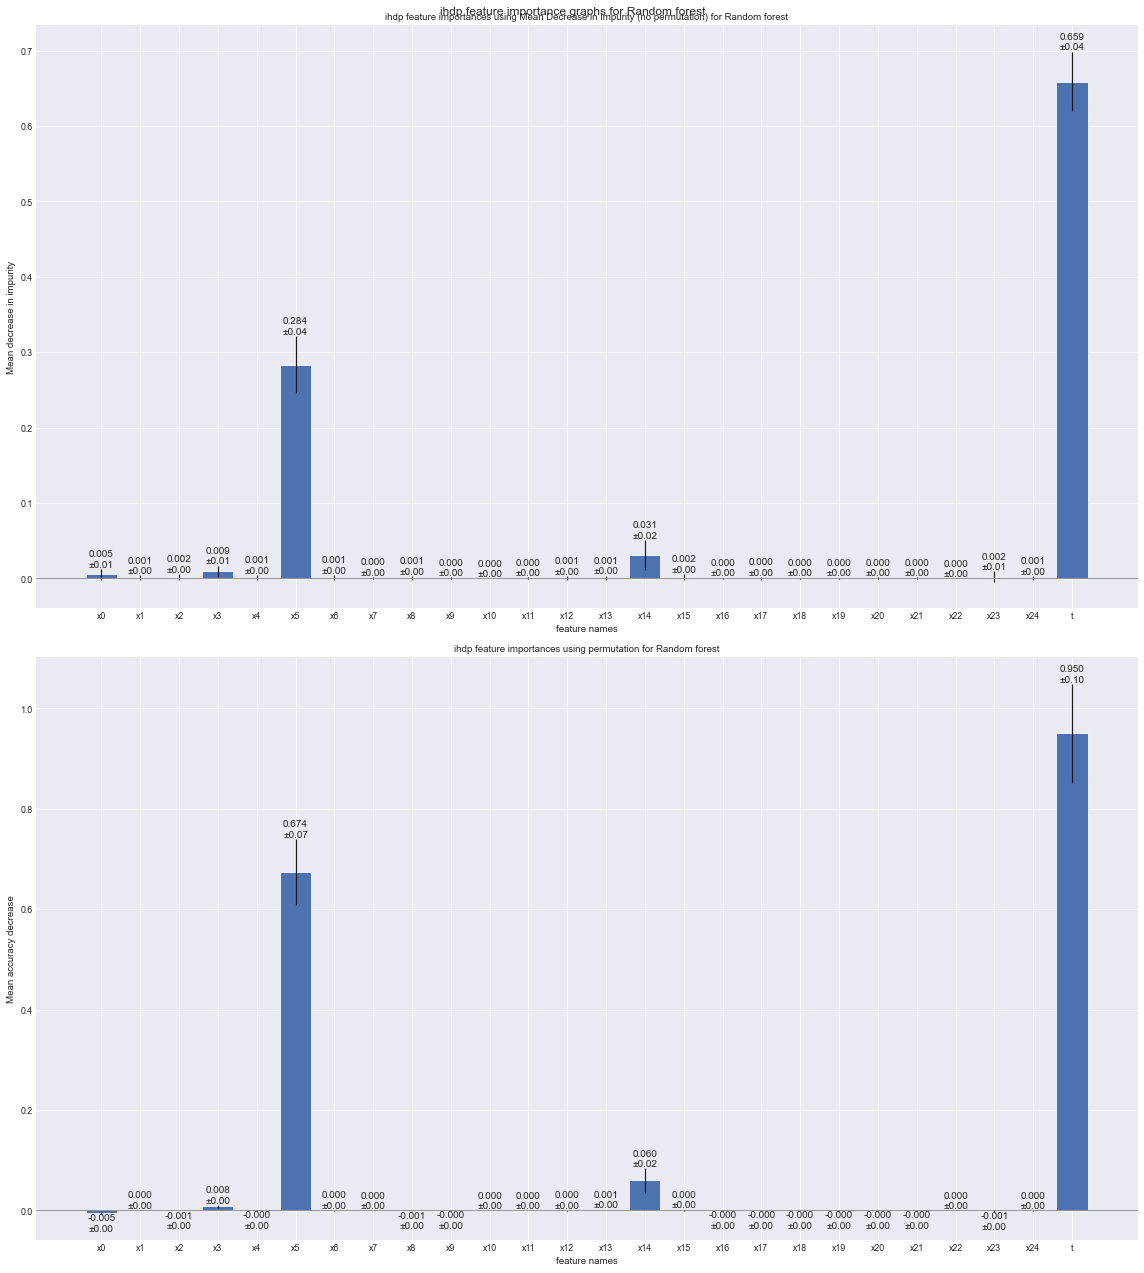

In [20]:
rf_searched.importance_plotter().show()

In [21]:
#ard_iter: List[int] = [200,300,400]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_searched_list: List[
    HalvingGridSearchResults
] = nested_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "regressor__tol": ard_tol,
        "regressor__alpha_1" : ard_alpha_lambda,
        "regressor__alpha_2" : ard_alpha_lambda,
        "regressor__lambda_1" : ard_alpha_lambda,
        "regressor__lambda_2" : ard_alpha_lambda,
        "regressor__threshold_lambda": ard_thresh_lambda
    },
    learn_x_t_data= ihdp_factuals_no_y,
    learn_y_targets = ihdp_factuals_y,
    regressor_name="ARD",
    learn_classes = ihdp_factuals_no_y["t"].to_numpy(),
    kfold_splits=10,
    resource="regressor__n_iter",
    true_t0_t1_ite_ycf= ihdp_full_nonfactuals
)

ard_searched: HalvingGridSearchResults = max(
    ard_searched_list
)

best_ard: Tuple[HalvingGridSearchResults, float] = (
    ard_searched,
    ard_searched.validation_fold_r2_score
)



-- 1/10 start --
max: 300, min: 75, factor: 2
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 3
min_resources_: 75
max_resources_: 300
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 729
n_resources: 75
Fitting 9 folds for each of 729 candidates, totalling 6561 fits
----------
iter: 1
n_candidates: 365
n_resources: 75
Fitting 9 folds for each of 365 candidates, totalling 3285 fits
----------
iter: 2
n_candidates: 183
n_resources: 75
Fitting 9 folds for each of 183 candidates, totalling 1647 fits
----------
iter: 3
n_candidates: 92
n_resources: 75
Fitting 9 folds for each of 92 candidates, totalling 828 fits
----------
iter: 4
n_candidates: 46
n_resources: 75
Fitting 9 folds for each of 46 candidates, totalling 414 fits
----------
iter: 5
n_candidates: 23
n_resources: 75
Fitting 9 folds for each of 23 candidates, totalling 207 fits
----------
iter: 6
n_candidates: 12
n_resources: 75
Fitting 9 folds for each of 12 candidates, totalling 108 fits
-

In [22]:

print(ard_searched.info())


ard_searched.best_estimator_


GridSearchResults: ARD ihdp
	estimator: Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                               lambda_2=1e-07, tol=0.01))])
	test r2: 0.7577410692997786
	train r2:0.6950396493460557
	yf r2:   0.7204090090854173
	ycf r2:  0.67042900294971
	ite r2:  -0.024908280274716033
	t0 r2:   0.48293578810438
	t1 r2:   -0.07231866946377274


Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                               lambda_2=1e-07, tol=0.01))])

In [23]:
ard_searched.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp ARD simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp ARD simple estimator.pickle
pickled estimator!


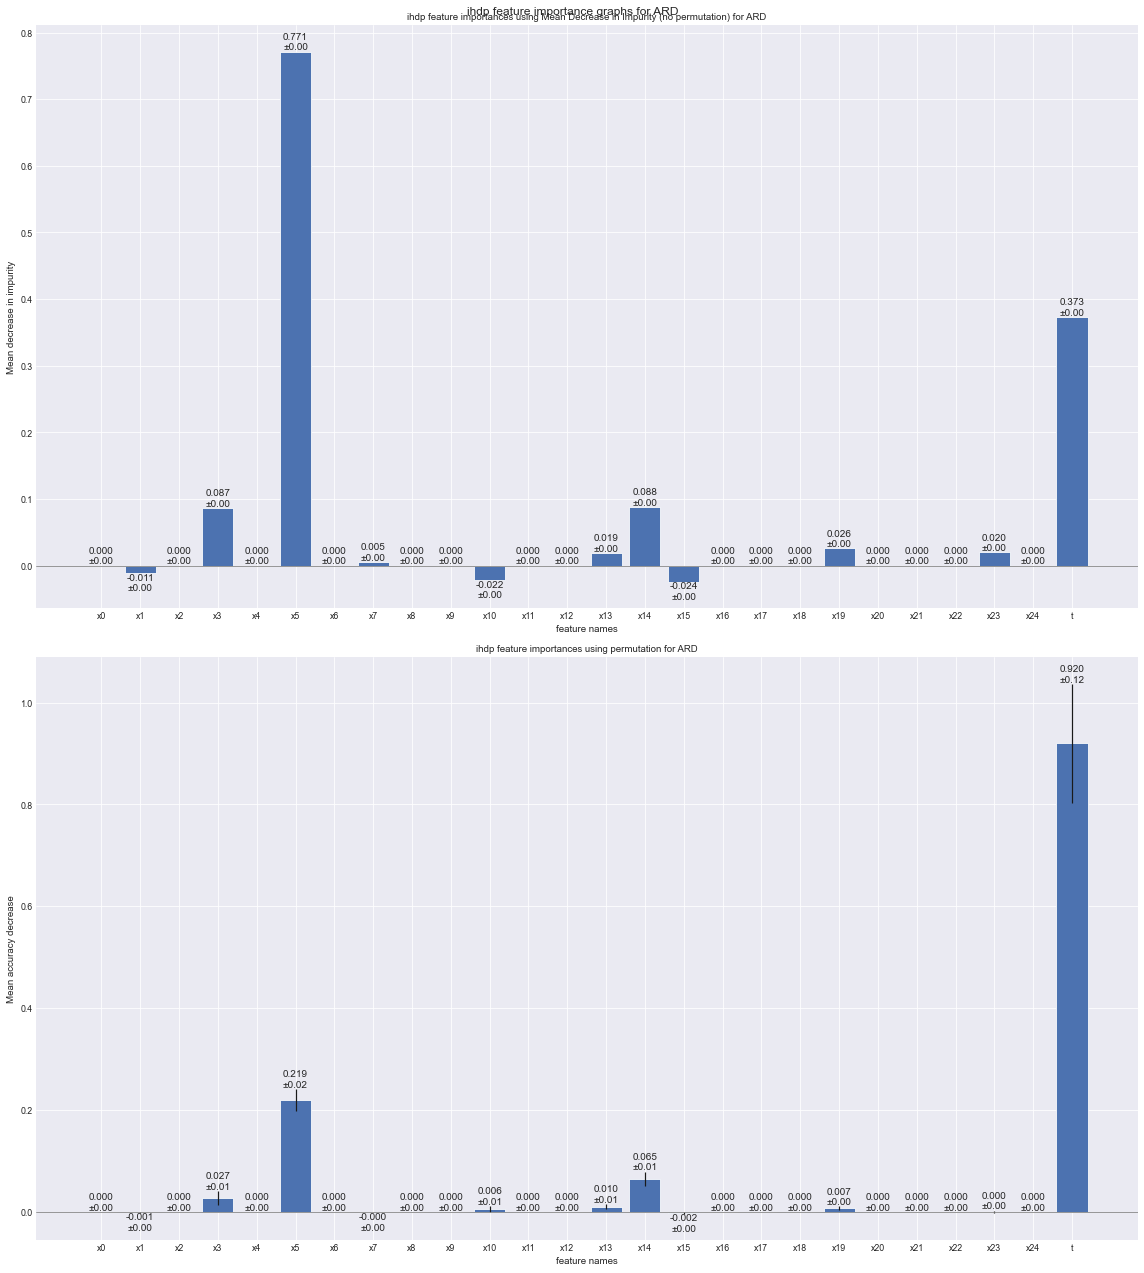

In [24]:
ard_searched.importance_plotter().show()

In [25]:


adaboost_estimators: List[int] = [40, 50, 60]
adaboost_learn_rate: List[float] = [0.8, 0.9, 1.0, 1.1, 1.2]
adaboost_loss: List[str]= ["linear", "square", "exponential"]

rf_ada_searched_list: List[
    HalvingGridSearchResults
] = nested_halving_grid_searcher(
    AdaBoostRegressor(
        random_state = _seed,
        base_estimator = Pipeline(
            steps = [i for i in rf_searched.best_estimator_.named_steps.items()]
        )
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "regressor__learning_rate": adaboost_learn_rate,
        "regressor__loss": adaboost_loss
    },
    learn_x_t_data= ihdp_factuals_no_y,
    learn_y_targets = ihdp_factuals_y,
    regressor_name="Adaboost random forest",
    learn_classes = ihdp_factuals_no_y["t"].to_numpy(),
    kfold_splits=10,
    resource="regressor__n_estimators",
    true_t0_t1_ite_ycf= ihdp_full_nonfactuals
)

rf_ada_searched: HalvingGridSearchResults = max(
    rf_ada_searched_list
)

best_rf_ada: Tuple[HalvingGridSearchResults, float] = (
    rf_ada_searched,
    rf_ada_searched.validation_fold_r2_score
)


-- 1/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2
max_resources_: 50
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 15
n_resources: 10
Fitting 9 folds for each of 15 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 3
n_resources: 50
Fitting 9 folds for each of 3 candidates, totalling 27 fits
-- 1/10 done. Score: 0.7003428117449225 --
-- 2/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2
max_resources_: 50
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 15
n_resources: 10
Fitting 9 folds for each of 15 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 3
n_resources: 50
Fitting 9 folds for each of 3 candidates, totalling 27 fits
-- 2/10 done. Score: 0.7001803527665756 --
-- 3/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possi

In [26]:

print(rf_ada_searched.info())



rf_ada_searched.best_estimator_


GridSearchResults: Adaboost random forest ihdp
	estimator: Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 AdaBoostRegressor(base_estimator=Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('regressor',
                                                                   RandomForestRegressor(ccp_alpha=0.027594593229224307,
                                                                                         max_features=None,
                                                                                        

Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 AdaBoostRegressor(base_estimator=Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('regressor',
                                                                   RandomForestRegressor(ccp_alpha=0.027594593229224307,
                                                                                         max_features=None,
                                                                                         min_impurity_decrease=0.0005253055608807533,
                                                                                         min_samples_split=4))]),
                                   learning_rate=0.8, random_state=42))])

In [27]:
rf_ada_searched.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost random forest simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost random forest simple estimator.pickle
pickled estimator!


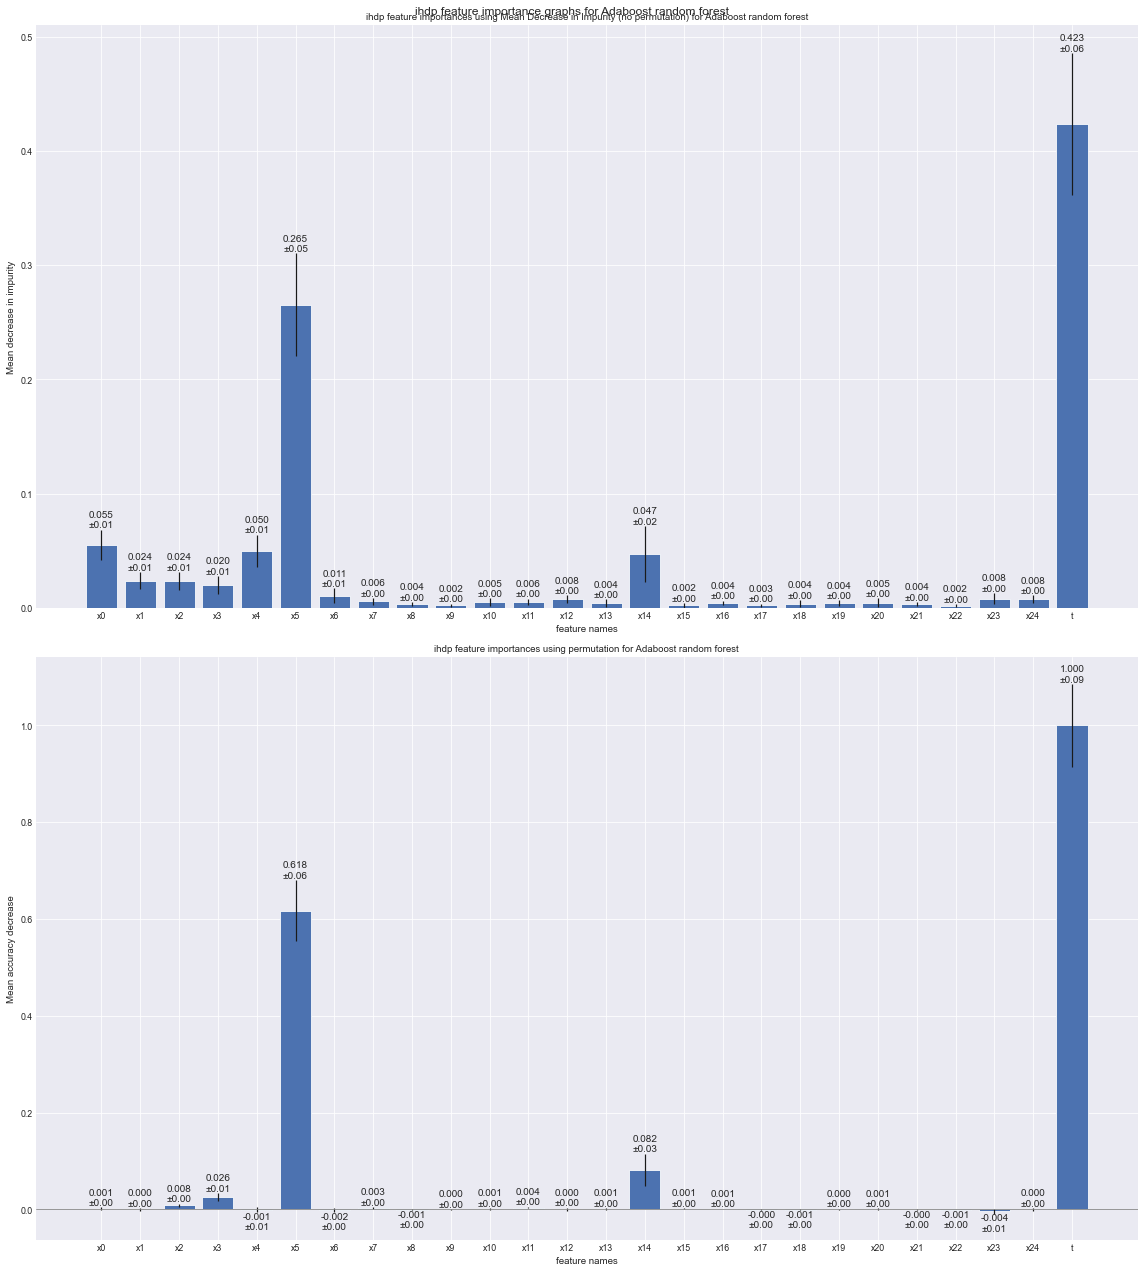

In [28]:
rf_ada_searched.importance_plotter().show()

In [29]:
ard_ada_searched_list: List[
    HalvingGridSearchResults
] = nested_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=_seed,
        base_estimator=Pipeline(
            steps = [i for i in ard_searched.best_estimator_.named_steps.items()]
        )
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "regressor__learning_rate": adaboost_learn_rate,
        "regressor__loss": adaboost_loss
    },
    learn_x_t_data= ihdp_factuals_no_y,
    learn_y_targets = ihdp_factuals_y,
    regressor_name="Adaboost ARD",
    learn_classes = ihdp_factuals_no_y["t"].to_numpy(),
    kfold_splits=10,
    resource="regressor__n_estimators",
    true_t0_t1_ite_ycf= ihdp_full_nonfactuals
)

ard_ada_searched: HalvingGridSearchResults = max(
    ard_ada_searched_list
)

best_ard_ada: Tuple[HalvingGridSearchResults, float] = (
    ard_ada_searched,
    ard_ada_searched.validation_fold_r2_score
)


-- 1/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2
max_resources_: 50
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 15
n_resources: 10
Fitting 9 folds for each of 15 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 3
n_resources: 50
Fitting 9 folds for each of 3 candidates, totalling 27 fits
-- 1/10 done. Score: 0.5905829496448499 --
-- 2/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2
max_resources_: 50
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 15
n_resources: 10
Fitting 9 folds for each of 15 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 3
n_resources: 50
Fitting 9 folds for each of 3 candidates, totalling 27 fits
-- 2/10 done. Score: 0.5483196672609347 --
-- 3/10 start --
max: 50, min: 2, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possi

In [30]:


print(ard_ada_searched.info())


ard_ada_searched.best_estimator_


GridSearchResults: Adaboost ARD ihdp
	estimator: Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 AdaBoostRegressor(base_estimator=Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('regressor',
                                                                   ARDRegression(alpha_1=1e-07,
                                                                                 alpha_2=1e-05,
                                                                                 lambda_1=1e-05,
                                      

Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 AdaBoostRegressor(base_estimator=Pipeline(steps=[('scaler',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('imputer',
                                                                   KNNImputer(weights='distance')),
                                                                  ('regressor',
                                                                   ARDRegression(alpha_1=1e-07,
                                                                                 alpha_2=1e-05,
                                                                                 lambda_1=1e-05,
                                                                                 lambda_2=1e-07,
                                                                                 tol=0.01))]),
                                   learning_rate=0.9, random_state=42))])

In [31]:
ard_ada_searched.save_me()

Pickling results to: D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost ARD simple results.pickle
pickled results!
Pickling simple estimator to D:\PycharmProjects\ce888\project\assignment2\ihdp\ihdp Adaboost ARD simple estimator.pickle
pickled estimator!


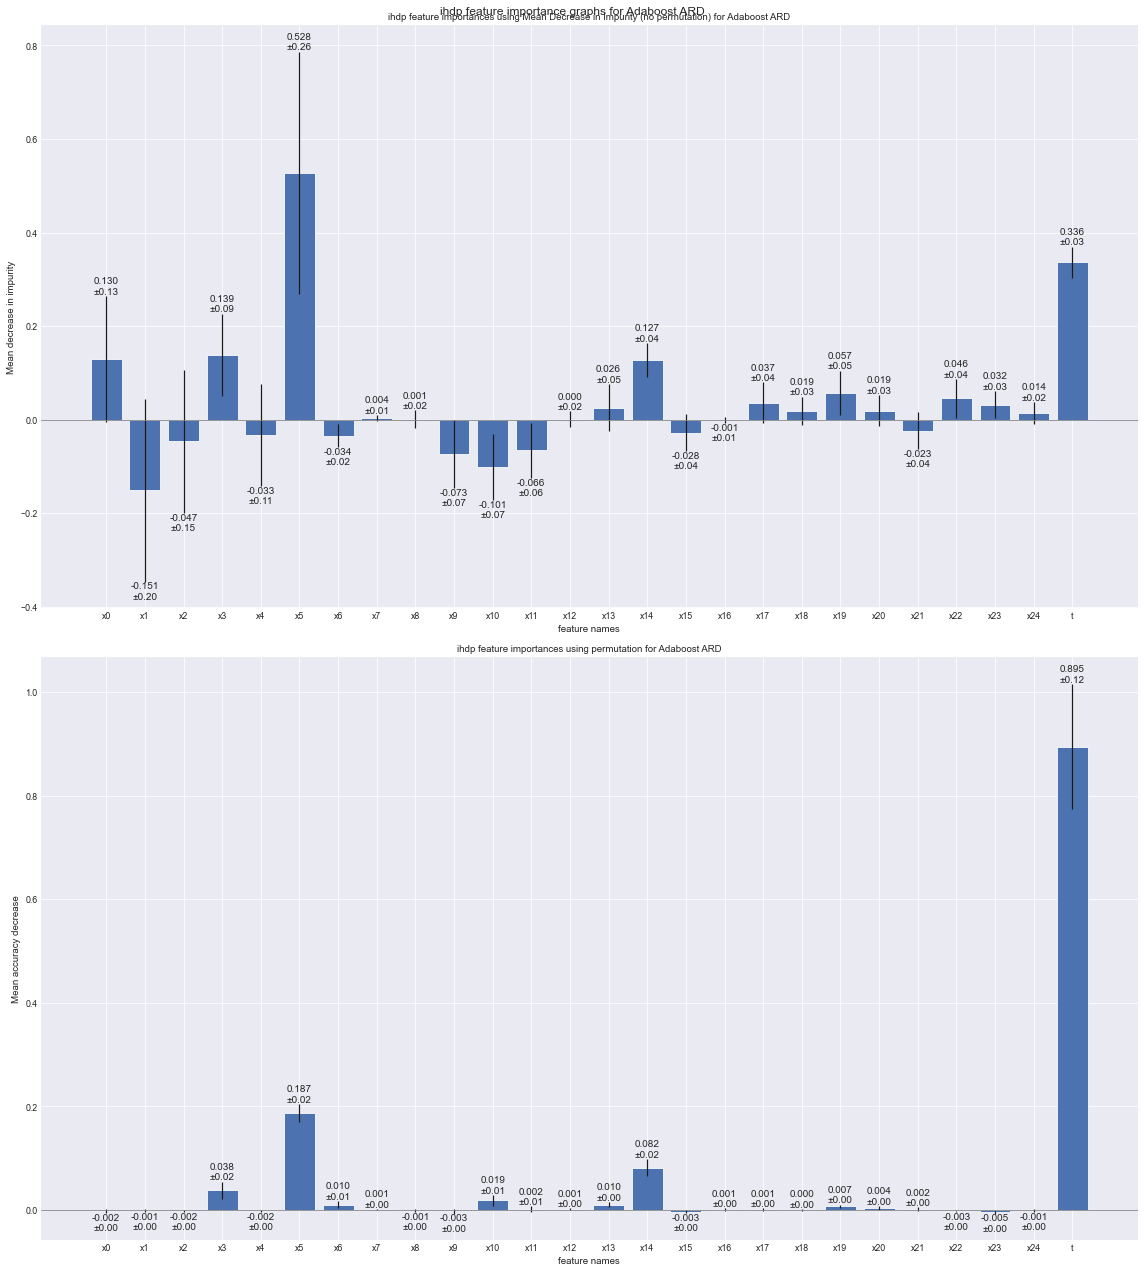

In [32]:
ard_ada_searched.importance_plotter().show()

In [33]:


all_best_classifiers: List[HalvingGridSearchResults] = [
    rf_searched,
    ard_searched,
    rf_ada_searched,
    ard_ada_searched
]

all_best_classifiers.sort(reverse=True)


In [34]:
for bc in all_best_classifiers:
    print(bc.summary_info())

print("")

GridSearchResults summary Adaboost random forest ihdp
	test r2: 0.8436054376562938
	train r2:0.7275027343092508
	yf r2:   0.9026026630981117
GridSearchResults summary Random forest ihdp
	test r2: 0.8321107521864692
	train r2:0.7495297311087695
	yf r2:   0.7957923019045026
GridSearchResults summary ARD ihdp
	test r2: 0.7577410692997786
	train r2:0.6950396493460557
	yf r2:   0.7204090090854173
GridSearchResults summary Adaboost ARD ihdp
	test r2: 0.7340580329571783
	train r2:0.6752113088145429
	yf r2:   0.7177201796613306

